In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import seaborn as sb
import missingno as msno

In [178]:
#Reading the dataset. 
df = pd.read_csv('complaints.csv')

/var/folders/3n/y6l_g9s960lc_759jvhdhxp40000gn/T/ipykernel_1466/4050258152.py:2: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complaints.csv')


## Initial data analysis.

In [179]:
#Data frame before performing data cleanup.
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-11-22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",OK,74447.0,Servicemember,NaN,Web,2022-11-22,In progress,Yes,NaN,6231498
1,2022-11-16,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,Experian Information Solutions Inc.,NJ,7093.0,NaN,NaN,Web,2022-11-16,In progress,Yes,NaN,6205383
2,2022-11-09,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Genesis FS Card Services, Inc.",TX,75038.0,NaN,NaN,Web,2022-11-09,Closed with explanation,Yes,NaN,6182699
3,2022-11-07,Mortgage,Other type of mortgage,Trouble during payment process,NaN,NaN,NaN,NORTHERN OHIO INVESTMENT COMPANY,MO,63031.0,NaN,Other,Web,2022-11-08,Untimely response,No,NaN,6173945
4,2022-11-07,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,"R & R Collection Service, Inc.",MO,64154.0,NaN,NaN,Phone,2022-11-07,Untimely response,No,NaN,6175998


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096756 entries, 0 to 3096755
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 425.

## Since we are only focused on the products and complaint narratives, we will extract only the 'Product' and 'Consumer complaint narrative' features.

In [181]:
df = df[['Product' , 'Consumer complaint narrative']]

In [182]:
#Rename attributes of dataframe for simplicity.
df = df.rename(columns={'Product' : "Product",
                       'Consumer complaint narrative' : "Complaint"})

In [183]:
#Data frame after renaming attributes.
df

,Product,Complaint
0,"Credit reporting, credit repair services, or o...",NaN
1,"Credit reporting, credit repair services, or o...",NaN
2,Debt collection,NaN
3,Mortgage,NaN
4,Debt collection,NaN
...,...,...
3096751,Debt collection,I have disputed my debts several times with no...
3096752,Mortgage,My father died in XX/XX/XXXX. Left me his only...
3096753,Credit reporting,cfbp i would Like to file a complaint on Exper...
3096754,Credit reporting,My husband and I are in the middle of an FHA S...


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096756 entries, 0 to 3096755
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Product    object
 1   Complaint  object
dtypes: object(2)
memory usage: 47.3+ MB


<AxesSubplot:xlabel='count', ylabel='Product'>

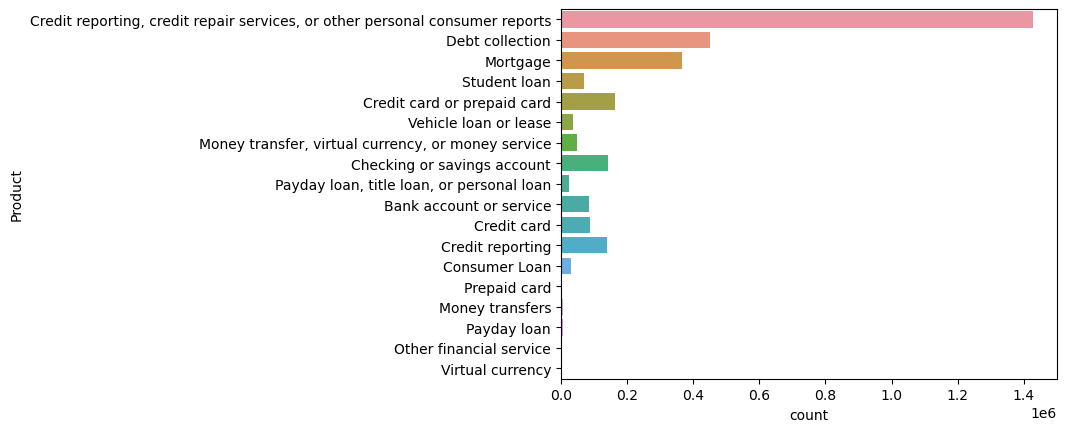

In [185]:
# Plotting the countplot for 'product' column
sb.countplot(data=df, y='Product')

In [186]:
df.groupby('Product').count()

,Complaint
Product,
Bank account or service,14885
Checking or savings account,54190
Consumer Loan,9470
Credit card,18838
Credit card or prepaid card,81787
Credit reporting,31588
"Credit reporting, credit repair services, or other personal consumer reports",514280
Debt collection,191946
"Money transfer, virtual currency, or money service",26556


## Products with similar titles can merged together into a single product.

In [187]:
#Clean up data by renaming similar products into one category of products.
df['Product'].replace({'Bank account or service': 'Banking Services',
                       'Checking or savings account' : 'Banking Services',
                       'Consumer Loan' : 'Loans',
                       'Credit card' : 'Credit/Prepaid Cards',
                       'Credit card or prepaid card' : 'Credit/Prepaid Cards',
                       'Credit reporting' : 'Credit Reporting and Services',
                       'Credit reporting, credit repair services, or other personal consumer reports' : 'Credit Reporting and Services',
                       'Debt collection' : 'Debt Collection',
                       'Money transfer, virtual currency, or money service' : 'Banking Services',
                       'Money transfers' : 'Banking Services',
                       'Mortgage' : 'Mortgages',
                       'Other financial service' : 'Banking Services',
                       'Payday loan' : 'Loans',
                       'Payday loan, title loan, or personal loan' : 'Loans',
                       'Prepaid card' : 'Credit/Prepaid Cards',
                       'Student loan' : 'Loans',
                       'Vehicle loan or lease' : 'Loans',
                       'Virtual currency' : 'Crypto Currency'}, inplace=True)

<AxesSubplot:xlabel='count', ylabel='Product'>

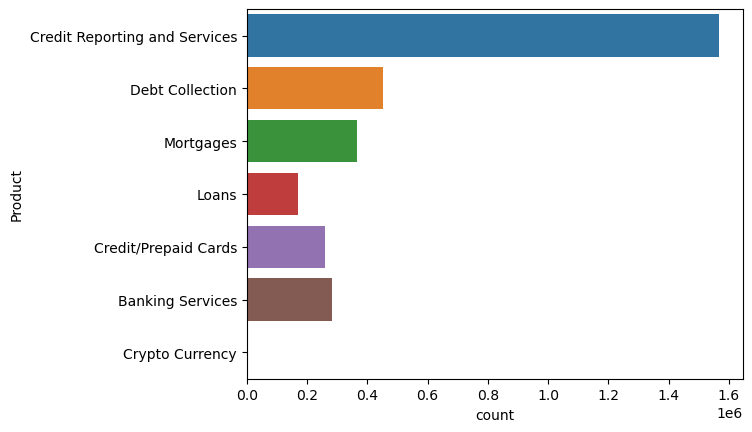

In [188]:
# Plotting the countplot for 'product' column
sb.countplot(data=df, y='Product')

In [189]:
#Refined products and their counts.
df.groupby('Product').count()

,Complaint
Product,
Banking Services,97420
Credit Reporting and Services,545868
Credit/Prepaid Cards,102075
Crypto Currency,16
Debt Collection,191946
Loans,77347
Mortgages,97748


In [190]:
#Data frame with refined product categories.
df

,Product,Complaint
0,Credit Reporting and Services,NaN
1,Credit Reporting and Services,NaN
2,Debt Collection,NaN
3,Mortgages,NaN
4,Debt Collection,NaN
...,...,...
3096751,Debt Collection,I have disputed my debts several times with no...
3096752,Mortgages,My father died in XX/XX/XXXX. Left me his only...
3096753,Credit Reporting and Services,cfbp i would Like to file a complaint on Exper...
3096754,Credit Reporting and Services,My husband and I are in the middle of an FHA S...


## Handling missing data.

In [191]:
#Check number of null values.
df[pd.isnull(df['Complaint'])]

,Product,Complaint
0,Credit Reporting and Services,NaN
1,Credit Reporting and Services,NaN
2,Debt Collection,NaN
3,Mortgages,NaN
4,Debt Collection,NaN
...,...,...
3096734,Loans,NaN
3096735,Loans,NaN
3096736,Mortgages,NaN
3096746,Banking Services,NaN


<AxesSubplot:>

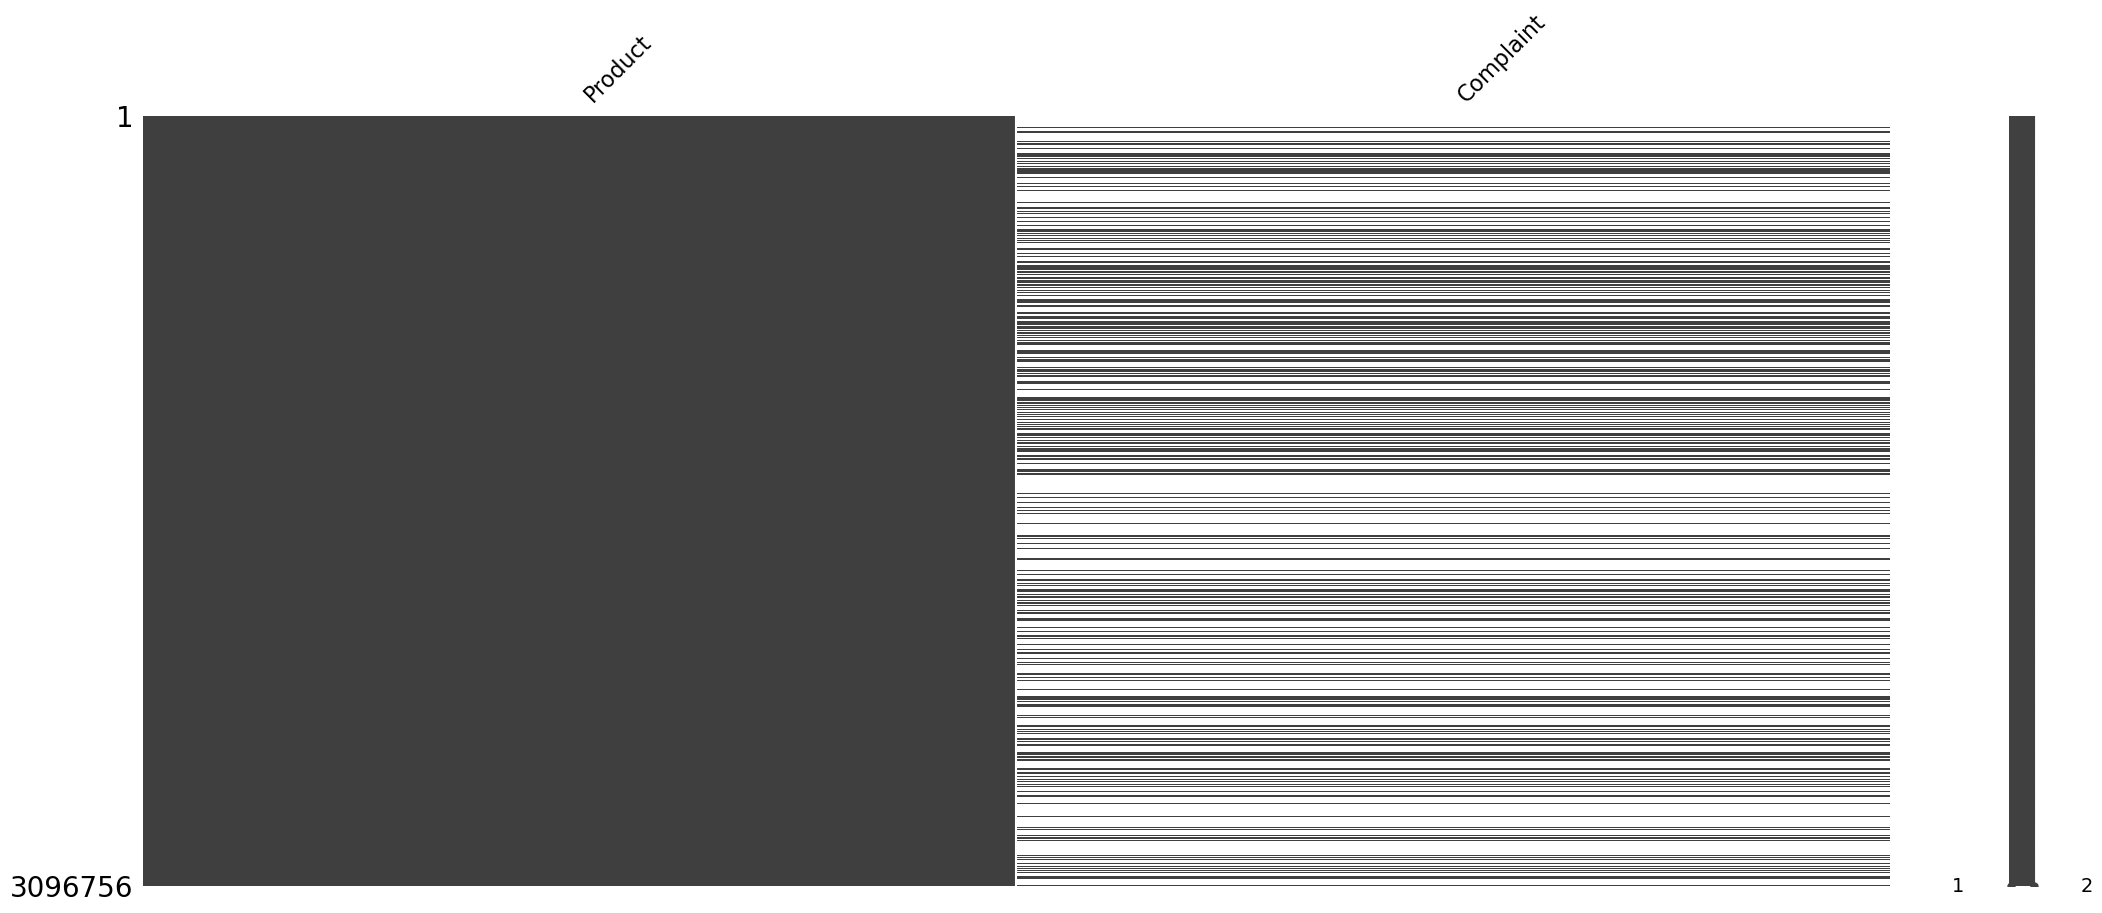

In [192]:
#Missingno matrix before dropping null values.
msno.matrix(df)

In [193]:
#Create new df to hold only non-null values of Consumer complaint narratives.
df = df[pd.notnull(df['Complaint'])]

In [194]:
df.shape

(1112420, 2)

<AxesSubplot:>

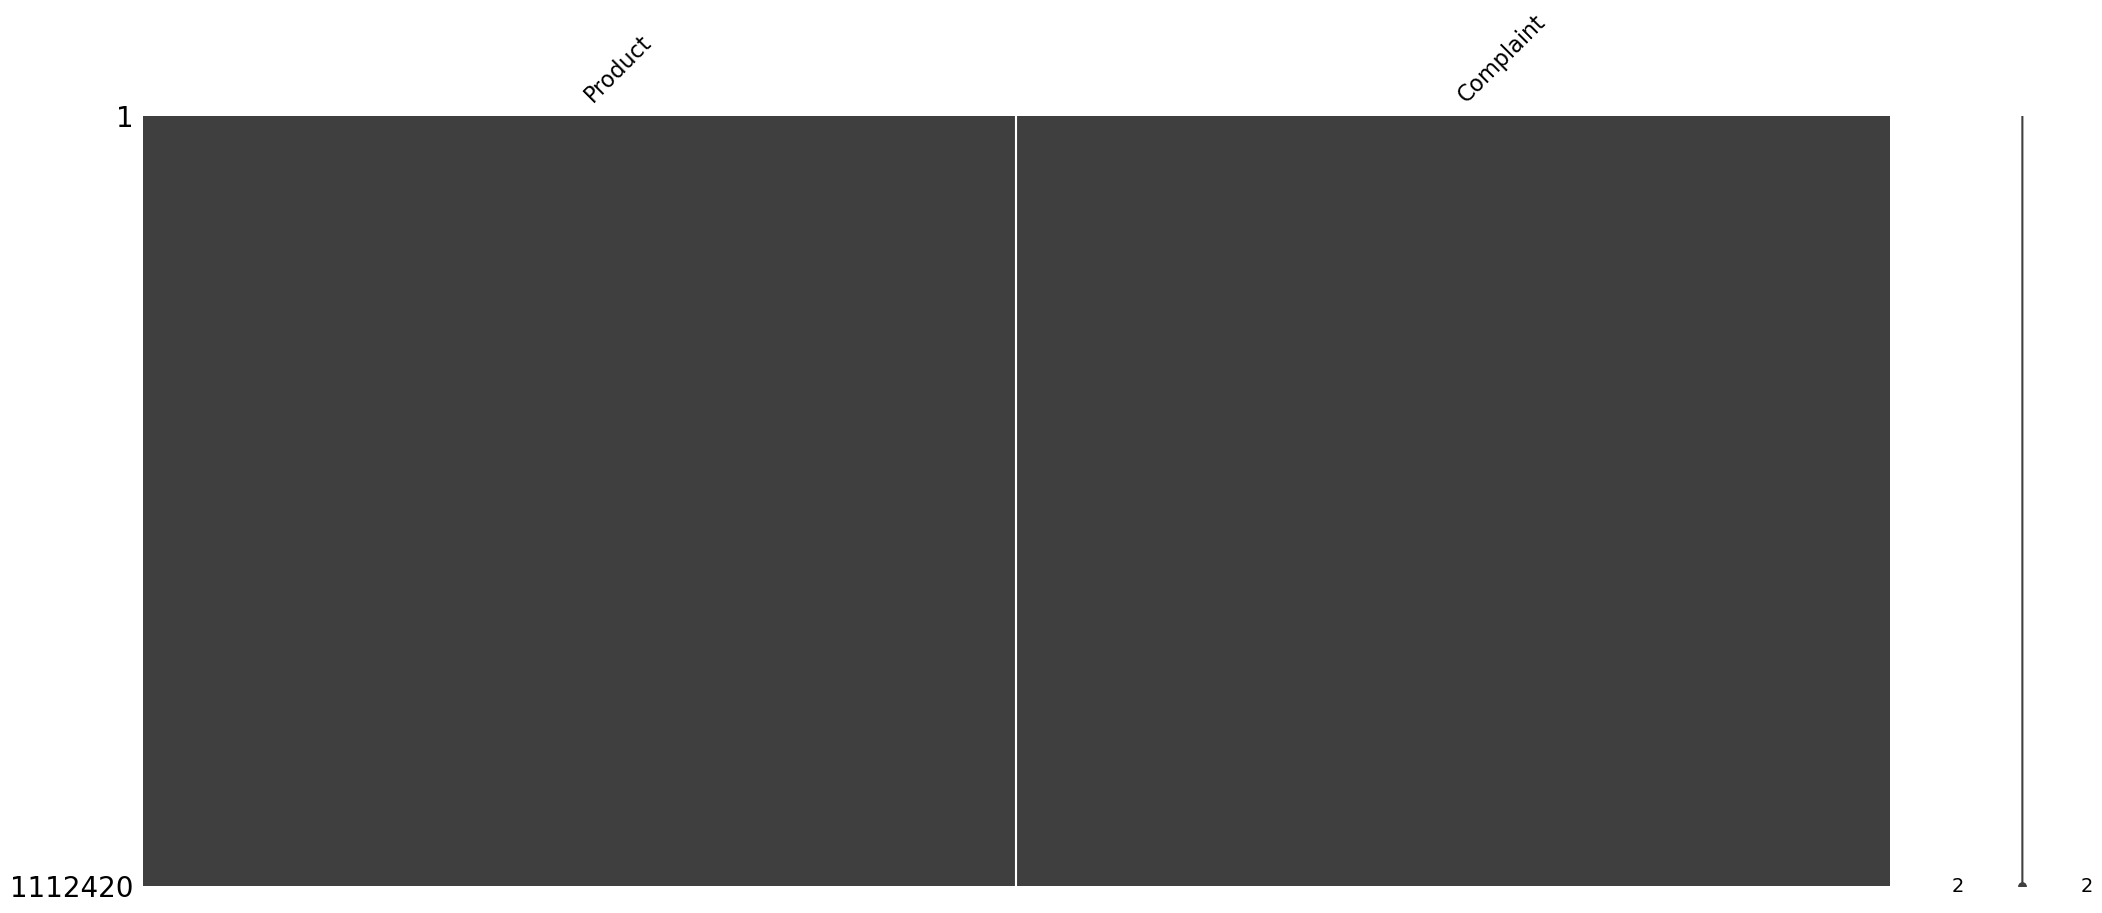

In [195]:
#Missingno matrix after dropping null values.
msno.matrix(df)

## Handling stop words, tokenization and lemmitization of complaint narratives.

In [196]:
#Sample complaint before preprocessing. 
df.Complaint[38]

'XXXX. I do not owe any money to XXXX  XXXX. I have never received a bill from XXXX indicating a balance due. \nXXXX. I have never received a Demand Letter from XXXX indicating if the amount due is not paid by XXXX date, collection action will begin XXXX. My payments for service are up to date [ no money for service is due ] XXXX. I have returned all equipment to XXXX XXXX for which I received a receipt.!! \nXXXX. XXXX has previously contracted for this with XXXX XXXX XXXX XXXX XXXX, and the XXXX XXXX, to which I provided the receipt and the same above information. It would appear XXXX is engaged in XXXX XXXX XXXX. \nXXXX. I have provided all this information to IC Systems XXXX IC Systems has NOW placed a derogatory item on my credit report.'

In [143]:
stop_words = stopwords.words('english') + list(string.punctuation)
stop_words += ["''", '""', '...', '``', '--', 'xxxx']

In [12]:
#Tokenize complaint data and remove stop words from complaint narrative.
def processComplaint(comp):
    tokens = nltk.word_tokenize(comp)
    removed_stop_words = [token.lower() for token in tokens if token.lower() not in stop_words]
    new_removed_stop_words = [word for word in removed_stop_words if word.isalpha()]
    
    return new_removed_stop_words

In [13]:
#Link words together.
def linkWords(words):
    linked_words = ''
    
    for w in words:
        linked_words += w + ' '
    
    return linked_words.strip()

In [14]:
lm = WordNetLemmatizer()

In [15]:
#Group variants of the same word and merge complaints.
def groupVariants(words):
    words = [word for word in words if word is not np.nan]
    
    lem_list = []
    
    for idx, word in enumerate(words):
        lem_list.append(lm.lemmatize(word))
    
    linked_str = linkWords(lem_list)
    
    return linked_str

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/ganesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ganesh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Tokenizing, lemmatizing, and removing stop words from complaint narratives.
### Note: This is a time consuming process...

In [17]:
# Eliminate stop words and group variants of words.
for i in range(len(df)):
    processed_complaints = processComplaint(df['Complaint'].iloc[i])
    complaint = groupVariants(processed_complaints)
    
    df['Complaint'].iloc[i] = complaint

    #Keep track of processed complaints.
    if i % 5000 == 0:
        print(f'Processed Row: {i}')

/var/folders/3n/y6l_g9s960lc_759jvhdhxp40000gn/T/ipykernel_20466/553799132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Complaint'].iloc[i] = complaint


Processed Row: 0
Processed Row: 5000
Processed Row: 10000
Processed Row: 15000
Processed Row: 20000
Processed Row: 25000
Processed Row: 30000
Processed Row: 35000
Processed Row: 40000
Processed Row: 45000
Processed Row: 50000
Processed Row: 55000
Processed Row: 60000
Processed Row: 65000
Processed Row: 70000
Processed Row: 75000
Processed Row: 80000
Processed Row: 85000
Processed Row: 90000
Processed Row: 95000
Processed Row: 100000
Processed Row: 105000
Processed Row: 110000
Processed Row: 115000
Processed Row: 120000
Processed Row: 125000
Processed Row: 130000
Processed Row: 135000
Processed Row: 140000
Processed Row: 145000
Processed Row: 150000
Processed Row: 155000
Processed Row: 160000
Processed Row: 165000
Processed Row: 170000
Processed Row: 175000
Processed Row: 180000
Processed Row: 185000
Processed Row: 190000
Processed Row: 195000
Processed Row: 200000
Processed Row: 205000
Processed Row: 210000
Processed Row: 215000
Processed Row: 220000
Processed Row: 225000
Processed Row

# Exporting processed dataset.

In [18]:
#Output processed complaints file.
df.to_csv('processed_complaints.csv')

In [199]:
#Reading processed dataset. 
ndf = pd.read_csv('processed_complaints.csv')

In [207]:
ndf

,Product,Complaint
0,Debt Collection,owe money never received bill indicating balan...
1,Debt Collection,attempting collect fund valuation service prov...
2,Credit Reporting and Services,experian didnt consent inquiry also name incor...
3,Banking Services,citibank froze account contained time make col...
4,Credit Reporting and Services,accordance fair credit reporting act account v...
...,...,...
1112415,Credit/Prepaid Cards,automated call capital one call home phone exc...
1112416,Debt Collection,disputed debt several time resolution submitte...
1112417,Mortgages,father died left son belonging also single mot...
1112418,Credit Reporting and Services,cfbp would like file complaint experian report...
